# Solver 3D
3D rendering of solver results

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from amdt import Simulator, Solver
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from tqdm import tqdm

In [2]:
s = Simulator()
gcode_commands = s.load_gcode_commands("3DBenchy.gcode")

100%|██████████| 86539/86539 [00:02<00:00, 40709.36it/s]


In [3]:
LAYER_INDEX = 10
START_INDEX = 0
END_INDEX = -1

In [4]:
gcode_layer_commands = s.get_gcode_commands_by_layer_change_index(LAYER_INDEX)
gcode_segments = s.gcode_commands_to_segments(gcode_layer_commands)
first_location = [gcode_segments[0]["X"][0]/1000, gcode_segments[0]["Y"][0]/1000]

100%|██████████| 298/298 [00:00<00:00, 422692.79it/s]


In [5]:
mesh = {
    "b_c": "temp",
    "x_location": first_location[0],
    "y_location": first_location[1],
    "x_min": 0.06,
    "x_max": 0.12,
    "y_min": 0.08,
    "y_max": 0.12,
    "z_min": -800e-6,
    "z_max": 0,
    "x_start_pad": 200e-6, 
    "y_start_pad": 200e-6,
    "x_end_pad": 200e-6, 
    "y_end_pad": 200e-6,
}
solver_et = Solver(mesh=mesh, verbose=True)
solver_r = Solver(mesh=mesh, verbose=True)

velocity = 800 # mm/s

thetas_r = []
thetas_et = []

for index in tqdm(range(len(gcode_segments))):


    line = gcode_segments[index]
    dt = line["distance_xy"] / velocity

    power = 200

    if line["travel"]:
        power = 0

    if dt > 0:
        solver_r.forward({"dt": dt, "phi": line["angle_xy"], "power": power}, model="rosenthal")
        thetas_r.append(solver_r.theta)

        solver_et.forward({"dt": dt, "phi": line["angle_xy"], "power": power})
        thetas_et.append(solver_et.theta)


Build Configuration
{'beam_diameter': 5e-05, 'power': 200.0, 't_0': 300.0, 'velocity': 0.8}

Material Configuration
{'absorptivity': 1.0,
 'c_p': 455.0,
 'k': 8.9,
 'rho': 7910.0,
 't_liquidus': 1710.26,
 't_melt': 1673.0,
 't_solidus': 1683.68}

Mesh Configuration
{'b_c': 'temp',
 'x_end_pad': 0.0002,
 'x_location': 0.093946,
 'x_max': 0.12,
 'x_min': 0.06,
 'x_start_pad': 0.0002,
 'x_step': 0.0001,
 'y_end_pad': 0.0002,
 'y_location': 0.091817,
 'y_max': 0.12,
 'y_min': 0.08,
 'y_start_pad': 0.0002,
 'y_step': 0.0001,
 'z_end_pad': 0.0001,
 'z_location': 0.0,
 'z_max': 0,
 'z_min': -0.0008,
 'z_start_pad': 0.0,
 'z_step': 0.0001}

Build Configuration
{'beam_diameter': 5e-05, 'power': 200.0, 't_0': 300.0, 'velocity': 0.8}

Material Configuration
{'absorptivity': 1.0,
 'c_p': 455.0,
 'k': 8.9,
 'rho': 7910.0,
 't_liquidus': 1710.26,
 't_melt': 1673.0,
 't_solidus': 1683.68}

Mesh Configuration
{'b_c': 'temp',
 'x_end_pad': 0.0002,
 'x_location': 0.093946,
 'x_max': 0.12,
 'x_min': 0.0

100%|██████████| 298/298 [1:43:45<00:00, 20.89s/it]  


In [6]:
np.savez("thetas_r.npz", data = thetas_r, compressions="gzip")
np.savez("thetas_et.npz", data = thetas_et, compressions="gzip")

In [7]:
loaded_thetas_r = np.load("thetas_r.npz")
loaded_thetas_et = np.load("thetas_et.npz")

In [8]:
thetas_r = loaded_thetas_r["data"]
print(len(thetas_r))
print(thetas_r[0].shape)

thetas_et = loaded_thetas_et["data"]
print(len(thetas_et))
print(thetas_et[0].shape)

277
(604, 405, 9)
277
(604, 405, 9)


In [9]:
clim = [310, 2000]
threshold = clim[0]
thresholded_voxels = [np.where(t <= threshold, False, t) for t in thetas_r]
cmap = plt.get_cmap("plasma")
norm = Normalize(vmin=clim[0], vmax=clim[1])
print(len(thresholded_voxels))

277


In [10]:
import gc

def plot_frame(frame_index):
    # Normalize your data for colormap
    title = f"frame_index {frame_index}"
    voxels = thresholded_voxels[frame_index]

    colors = cmap(norm(voxels))

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')

    x_dim, y_dim, z_dim = voxels.shape  # Dimensions of the voxel grid

    ax.set_xlim([0, x_dim])
    ax.set_ylim([0, y_dim])
    ax.set_zlim([0, z_dim])

    # Remove tick markers
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    # Hide axis lines and panes
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.zaxis.set_visible(False)

    ax.set_title(title)

    # Calculate the maximum extent for equal aspect ratio
    max_extent = max(x_dim, y_dim, z_dim)

    # Center and scale each axis to have equal aspect ratio
    ax.set_box_aspect((x_dim / max_extent, y_dim / max_extent, z_dim / max_extent))

    ax.voxels(
        voxels,
        facecolors=colors,
        edgecolors=np.clip(2 * colors - 0.5, 0, 1),
        linewidth=0.5
    )

    # Add color bar
    mappable = ScalarMappable(norm=norm, cmap=cmap)
    mappable.set_array([])  # This line is necessary to avoid errors

    # Add the color bar to the figure
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10)
    cbar.set_label("temperature")
    filename = f"{frame_index}".zfill(4)
    plt.savefig(f"solver_3d_r/{filename}.png")

    # Explicitly clean up large variables to free memory
    del voxels  # Release the reference to the frame's voxel data
    del fig     # Release the figure object
    del ax      # Release the axis object

    # Optional: Call garbage collection to free memory immediately
    gc.collect()  # This will clean up unused memory within this process


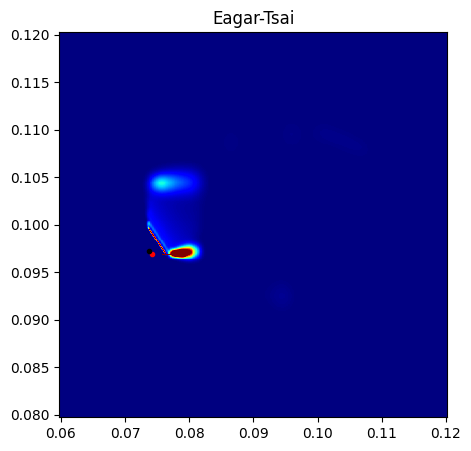

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
frame_index = 270
voxels = thresholded_voxels[frame_index]

ax.set_title("Eagar-Tsai")
ax.pcolormesh(solver_et.xs, solver_et.ys, voxels[:, :, -1].T, cmap = 'jet', vmin = 310, vmax = 1923)
ax.plot(solver_et.location[0], solver_et.location[1] ,'r.')
ax.plot(solver_et.xs[solver_et.location_idx[0]], solver_et.ys[solver_et.location_idx[1]], 'k.')

In [12]:
import multiprocessing
import gc

def plot_frames_in_parallel(frame_indices):
    # Create a Pool of workers to process multiple frames in parallel
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        pool.map(plot_frame, frame_indices)

    gc.collect()

# Example usage
frame_indices = range(len(thresholded_voxels))  # Example frame indices
# frame_indices = range(0, 100)  # Example frame indices
plot_frames_in_parallel(frame_indices)

In [13]:
import os
import imageio

def create_gif_from_images(image_folder, gif_filename="output.gif"):
    # List all files in the folder and sort them by filename
    image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.png')])

    # Create a list to store images
    images = []
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        images.append(imageio.imread(image_path))

    # Create the GIF
    imageio.mimsave(gif_filename, images, duration=0.1, loop=0)  # You can adjust the duration

    print(f"GIF saved as {gif_filename}")

In [14]:
create_gif_from_images("solver_3d_r", "r.gif")

/tmp/ipykernel_230409/3917812420.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(image_path))


GIF saved as r.gif
